## Analysis of Qiskit results

#### Imports

In [20]:
import numpy as np
import json
from qiskit import QuantumCircuit, transpile, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

#### Compute the circuit

In [22]:
# --------------------------
# Load one-body data
# --------------------------
data_onebody = np.load('data/matrix_elements_h_eff_2body/one_body_nn_p.npz')
keys = data_onebody['keys']
values = data_onebody['values']
n_qubits = 3

t_onebody = {}
for a, key in enumerate(keys):
    i, j = key
    t_onebody[(i, j)] = values[a]

# Build target Hamiltonian
from src.qiskit_utils import get_hamiltonian
hamiltonian_q = get_hamiltonian(t_onebody, n_qubits)

# Driver Hamiltonian
coupling_term = -8.4321
Z_tuples = [("Z", [0], -0.5*coupling_term)]
I_tuples = [('I', [0], 0.5*coupling_term)]
hamiltonian_driver = SparsePauliOp.from_sparse_list([*Z_tuples, *I_tuples], num_qubits=n_qubits)

# --------------------------
# Time evolution circuit
# --------------------------
time_steps = 10
tf = 1
time = np.linspace(0, tf, time_steps)
dt = tf / time_steps
driver = 1 - time/tf

circuit_time_evolution = QuantumCircuit(hamiltonian_q.num_qubits)
circuit_time_evolution.x([0])  # initial state

for n, t in enumerate(time):
    hamiltonian_t = (driver[n])*hamiltonian_driver + (1-driver[n])*hamiltonian_q
    exp_H_t = PauliEvolutionGate(hamiltonian_t, time=dt, synthesis=SuzukiTrotter(order=1))
    circuit_time_evolution.append(exp_H_t, range(hamiltonian_q.num_qubits))


# --------------------------
# Measurement circuits
# --------------------------
creg = ClassicalRegister(n_qubits)

# Z basis
circuit_z = circuit_time_evolution.copy()
circuit_z.add_register(creg)
circuit_z.measure(range(n_qubits), range(n_qubits))

# X basis
circuit_x = circuit_time_evolution.copy()
circuit_x.add_register(creg)
circuit_x.h(range(n_qubits))
circuit_x.measure(range(n_qubits), range(n_qubits))

# Y basis
circuit_y = circuit_time_evolution.copy()
circuit_y.add_register(creg)
circuit_y.sdg(range(n_qubits))
circuit_y.h(range(n_qubits))
circuit_y.measure(range(n_qubits), range(n_qubits))

In [50]:
from qiskit.quantum_info import Statevector

# --------------------------
# Run using Statevector (no Aer)
# --------------------------

# Evolve the initial state through the circuit
final_state = Statevector(circuit_time_evolution)

print('OBS ESTIMATION=',final_state.expectation_value(hamiltonian_q[0]).real,'\n')

print("Final statevector:")
print(final_state.data)

# Optional: compute measurement probabilities in Z basis
probs_z = final_state.probabilities_dict()
print("\nZ-basis probabilities:")
for bitstring, prob in probs_z.items():
    print(f"{bitstring}: {prob:.4f}")

# If you want to get results in X or Y basis:
# Just apply the corresponding basis-change gates to the statevector

# X basis
state_x = final_state.copy()
state_x = state_x.evolve(circuit_x.remove_final_measurements(inplace=False))
probs_x = state_x.probabilities_dict()
print("\nX-basis probabilities:")
for bitstring, prob in probs_x.items():
    print(f"{bitstring}: {prob:.4f}")

# Y basis
state_y = final_state.copy()
state_y = state_y.evolve(circuit_y.remove_final_measurements(inplace=False))
probs_y = state_y.probabilities_dict()
print("\nY-basis probabilities:")
for bitstring, prob in probs_y.items():
    print(f"{bitstring}: {prob:.4f}")

OBS ESTIMATION= -0.10643579581353739 

Final statevector:
[ 0.        +0.j         -0.34688996-0.02117245j  0.33567927+0.73495764j
  0.        +0.j         -0.39376407-0.25229242j  0.        +0.j
  0.        +0.j         -0.08617924+0.01572631j]

Z-basis probabilities:
001: 0.1208
010: 0.6528
100: 0.2187
111: 0.0077

X-basis probabilities:
000: 0.1009
001: 0.0680
010: 0.1788
011: 0.1524
100: 0.1524
101: 0.1788
110: 0.0680
111: 0.1009

Y-basis probabilities:
000: 0.0026
001: 0.0281
010: 0.4545
011: 0.0147
100: 0.0147
101: 0.4545
110: 0.0281
111: 0.0026


#### Load the results

In [23]:
import json

# Load hardware histograms
with open("histogram_z.json", "r") as f:
    hist_z = json.load(f)

with open("histogram_x.json", "r") as f:
    hist_x = json.load(f)

with open("histogram_y.json", "r") as f:
    hist_y = json.load(f)

2048


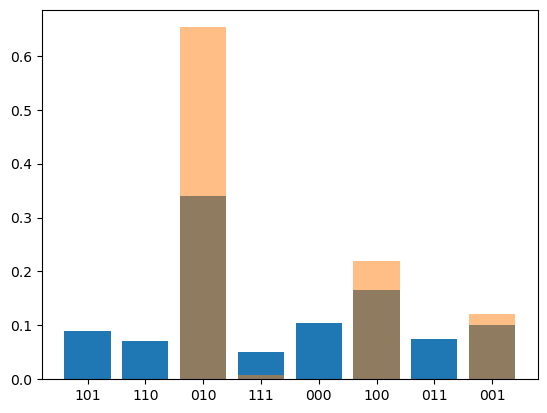

In [28]:
import matplotlib.pyplot as plt

hist_z_values=np.asarray(list(hist_z.values()))
plt.bar(hist_z.keys(), hist_z_values/hist_z_values.sum())
plt.bar(probs_z.keys(), np.asarray(list(probs_z.values())), alpha=0.5)
print(hist_z_values.sum())
plt.show()

#### Compute energy expectation value

In [45]:
import numpy as np
from collections import Counter

frequencies={}
countss=[hist_x, hist_y, probs_z]
countss=[probs_x, probs_y, probs_z]
labels=['X','Y','Z']
shots=2048
for r,counts in enumerate(countss):
    # Example counts from shots
    shots = sum(counts.values())
    bitstring=list(counts.keys())
    values=list(counts.values())
    measures={}
    for i in range(len(bitstring)):
        arr=np.array([2*(int(b)-0.5) for b in bitstring[i]])
        measures[tuple(arr)]=values[i]/shots
    frequencies[labels[r]]=measures

In [46]:


energy_component_z=0.
energy_component_y=0.
energy_component_x=0.
for (i,j),value in t_onebody.items():
    print(i,j,value)
    if i!=j:    
        freq= frequencies['Y']
        for key in freq.keys():
            print(int(key[i]),int(key[j]))
            energy_component_y+=0.25*value*int(key[i])*int(key[j])*freq[key]
        freq= frequencies['X']
        for key in freq.keys():
            energy_component_x+=0.25*value*int(key[i])*int(key[j])*freq[key]
                  
    elif i==j:
        # we convert the projector from Z+I to I-Z, because in qibo our 1 is 0 and viceversa
        freq= frequencies['Z']
        for key in freq.keys():
            print(int(key[i]),int(key[j]))
            energy_component_z+=0.5*value*(int(key[i])+1)*freq[key]

0 0 -8.4321
-1 -1
-1 -1
1 1
1 1
0 1 1.0430999999999995
-1 -1
-1 -1
-1 1
-1 1
1 -1
1 -1
1 1
1 1
0 2 -3.763858685577873
-1 -1
-1 1
-1 -1
-1 1
1 -1
1 1
1 -1
1 1
1 0 1.0430999999999995
-1 -1
-1 -1
1 -1
1 -1
-1 1
-1 1
1 1
1 1
1 1 -8.4321
-1 -1
1 1
-1 -1
1 1
1 2 3.763858685577873
-1 -1
-1 1
1 -1
1 1
-1 -1
-1 1
1 -1
1 1
2 0 -3.763858685577873
-1 -1
1 -1
-1 -1
1 -1
-1 1
1 1
-1 1
1 1
2 1 3.763858685577873
-1 -1
1 -1
-1 1
1 1
-1 -1
1 -1
-1 1
1 1
2 2 -5.1203
1 1
-1 -1
-1 -1
1 1


In [44]:
print(energy_component_x+energy_component_y+energy_component_z)

-9.661123505330004
